In [1]:
# Step 1: Clone repo and install dependencies (run once)
!git clone https://github.com/Trustworthy-ML-Lab/CLIP-dissect.git
%cd CLIP-dissect

Cloning into 'CLIP-dissect'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 104 (delta 12), reused 14 (delta 8), pack-reused 80 (from 1)
Receiving objects: 100% (104/104), 15.94 MiB | 35.73 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/kaggle/working/CLIP-dissect


In [4]:
cd /kaggle/working/CLIP-dissect

/kaggle/working/CLIP-dissect


In [5]:

# Install Python requirements (use a virtualenv if you like)
!pip install -r requirements.txt

# Download Broden dataset (needed for probing)
!bash dlbroden.sh

# Download pretrained models (including resnet18_places365)
!bash dlzoo_example.sh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 30.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.9 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You

In [7]:
!pip install ftfy

  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)


In [25]:
# %load "/kaggle/working/CLIP-dissect/data_utils.py"
import os
import torch
import pandas as pd
from torchvision import datasets, transforms, models

DATASET_ROOTS = {"imagenet_val": "YOUR_PATH/ImageNet_val/",
                "broden": "data/broden1_224/images/"}

print("updated data utils file")

def get_target_model(target_name, device):
    """
    Returns the target model in eval mode and its preprocess function.
    Supported target_names:
    - 'resnet18' for ImageNet pretrained ResNet18 (from torchvision)
    - 'resnet18_places' for Places365 ResNet18 (manual load)
    - other resnets from torchvision
    """

    import torch
    from torchvision import models
    from data_utils import get_resnet_imagenet_preprocess

    if target_name == 'resnet18_places':
        # Load ResNet18 Places365 manually
        target_model = models.resnet18(num_classes=365).to(device)
        checkpoint = torch.load('/kaggle/working/CLIP-dissect/data/resnet18_places365.pth.tar', map_location=device)
        state_dict = checkpoint['state_dict']
        new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        target_model.load_state_dict(new_state_dict)
        target_model.eval()
        preprocess = get_resnet_imagenet_preprocess()

    elif target_name == 'resnet18':
        # Load pretrained ResNet18 from torchvision for ImageNet
        from torchvision.models import resnet18, ResNet18_Weights
        weights = ResNet18_Weights.IMAGENET1K_V1
        target_model = resnet18(weights=weights).to(device)
        target_model.eval()
        preprocess = weights.transforms()

    # elif "resnet" in target_name:
    #     # Load other torchvision resnet models
    #     target_name_cap = target_name.replace("resnet", "ResNet")
    #     weights = eval(f"models.{target_name_cap}_Weights.IMAGENET1K_V1")
    #     preprocess = weights.transforms()
    #     target_model = eval(f"models.{target_name_cap}(weights=weights).to(device)")
    #     target_model.eval()

    else:
        raise ValueError(f"Unsupported model: {target_name}")

    return target_model, preprocess


# def get_target_model(target_name, device):
#     """
#     returns target model in eval mode and its preprocess function
#     target_name: supported options - {resnet18_places, resnet18, resnet34, resnet50, resnet101, resnet152}
#                  except for resnet18_places this will return a model trained on ImageNet from torchvision
                 
#     To Dissect a different model implement its loading and preprocessing function here
#     """
#     if target_name == 'resnet18_places': 
#         target_model = models.resnet18(num_classes=365).to(device)
#         state_dict = torch.load('/kaggle/CLIP-dissect/resnet18_places365.pth.tar')['state_dict']
#         new_state_dict = {}
#         for key in state_dict:
#             if key.startswith('module.'):
#                 new_state_dict[key[7:]] = state_dict[key]
#         target_model.load_state_dict(new_state_dict)
#         target_model.eval()
#         preprocess = get_resnet_imagenet_preprocess()
#     elif target_name == 'resnet18_imagenet':
#         from torchvision.models import resnet18, ResNet18_Weights
#         weights = ResNet18_Weights.IMAGENET1K_V1
#         target_model = resnet18(weights=weights).to(device)
#         target_model.eval()
#         preprocess = weights.transforms()
#     elif "vit_b" in target_name:
#         target_name_cap = target_name.replace("vit_b", "ViT_B")
#         weights = eval("models.{}_Weights.IMAGENET1K_V1".format(target_name_cap))
#         preprocess = weights.transforms()
#         target_model = eval("models.{}(weights=weights).to(device)".format(target_name))
#     elif "resnet" in target_name:
#         target_name_cap = target_name.replace("resnet", "ResNet")
#         weights = eval("models.{}_Weights.IMAGENET1K_V1".format(target_name_cap))
#         preprocess = weights.transforms()
#         target_model = eval("models.{}(weights=weights).to(device)".format(target_name))
    
#     target_model.eval()
#     return target_model, preprocess

def get_resnet_imagenet_preprocess():
    target_mean = [0.485, 0.456, 0.406]
    target_std = [0.229, 0.224, 0.225]
    preprocess = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                   transforms.ToTensor(), transforms.Normalize(mean=target_mean, std=target_std)])
    return preprocess

def get_data(dataset_name, preprocess=None):
    if dataset_name == "cifar100_train":
        data = datasets.CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=True,
                                   transform=preprocess)

    elif dataset_name == "cifar100_val":
        data = datasets.CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False, 
                                   transform=preprocess)
        
    elif dataset_name in DATASET_ROOTS.keys():
        data = datasets.ImageFolder(DATASET_ROOTS[dataset_name], preprocess)
               
    elif dataset_name == "imagenet_broden":
        data = torch.utils.data.ConcatDataset([datasets.ImageFolder(DATASET_ROOTS["imagenet_val"], preprocess), 
                                                     datasets.ImageFolder(DATASET_ROOTS["broden"], preprocess)])
        
    return data


def get_places_id_to_broden_label():
    with open("data/categories_places365.txt", "r") as f:
        places365_classes = f.read().split("\n")
    
    broden_scenes = pd.read_csv('data/broden1_224/c_scene.csv')
    id_to_broden_label = {}
    for i, cls in enumerate(places365_classes):
        name = cls[3:].split(' ')[0]
        name = name.replace('/', '-')
        
        found = (name+'-s' in broden_scenes['name'].values)
        
        if found:
            id_to_broden_label[i] = name.replace('-', '/')+'-s'
        if not found:
            id_to_broden_label[i] = None
    return id_to_broden_label
    
def get_cifar_superclass():
    cifar100_has_superclass = [i for i in range(7)]
    cifar100_has_superclass.extend([i for i in range(33, 69)])
    cifar100_has_superclass.append(70)
    cifar100_has_superclass.extend([i for i in range(72, 78)])
    cifar100_has_superclass.extend([101, 104, 110, 111, 113, 114])
    cifar100_has_superclass.extend([i for i in range(118, 126)])
    cifar100_has_superclass.extend([i for i in range(147, 151)])
    cifar100_has_superclass.extend([i for i in range(269, 281)])
    cifar100_has_superclass.extend([i for i in range(286, 298)])
    cifar100_has_superclass.extend([i for i in range(300, 308)])
    cifar100_has_superclass.extend([309, 314])
    cifar100_has_superclass.extend([i for i in range(321, 327)])
    cifar100_has_superclass.extend([i for i in range(330, 339)])
    cifar100_has_superclass.extend([345, 354, 355, 360, 361])
    cifar100_has_superclass.extend([i for i in range(385, 398)])
    cifar100_has_superclass.extend([409, 438, 440, 441, 455, 463, 466, 483, 487])
    cifar100_doesnt_have_superclass = [i for i in range(500) if (i not in cifar100_has_superclass)]
    
    return cifar100_has_superclass, cifar100_doesnt_have_superclass

updated data utils file


In [15]:
# %load "/kaggle/working/CLIP-dissect/describe_neurons.py"
import os
import argparse
import datetime
import json
import pandas as pd
import torch

import utils
import similarity


parser = argparse.ArgumentParser(description='CLIP-Dissect')

parser.add_argument("--clip_model", type=str, default="ViT-B/16", 
                    choices=['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14'],
                   help="Which CLIP-model to use")
parser.add_argument("--target_model", type=str, default="resnet50", 
                   help=""""Which model to dissect, supported options are pretrained imagenet models from
                        torchvision and resnet18_places""")
parser.add_argument("--target_layers", type=str, default="conv1,layer1,layer2,layer3,layer4",
                    help="""Which layer neurons to describe. String list of layer names to describe, separated by comma(no spaces). 
                          Follows the naming scheme of the Pytorch module used""")
parser.add_argument("--d_probe", type=str, default="broden", 
                    choices = ["imagenet_broden", "cifar100_val", "imagenet_val", "broden", "imagenet_broden"])
parser.add_argument("--concept_set", type=str, default="data/20k.txt", help="Path to txt file containing concept set")
parser.add_argument("--batch_size", type=int, default=200, help="Batch size when running CLIP/target model")
parser.add_argument("--device", type=str, default="cuda", help="whether to use GPU/which gpu")
parser.add_argument("--activation_dir", type=str, default="saved_activations", help="where to save activations")
parser.add_argument("--result_dir", type=str, default="results", help="where to save results")
parser.add_argument("--pool_mode", type=str, default="avg", help="Aggregation function for channels, max or avg")
parser.add_argument("--similarity_fn", type=str, default="soft_wpmi", choices=["soft_wpmi", "wpmi", "rank_reorder", 
                                                                               "cos_similarity", "cos_similarity_cubed"])

parser.parse_args()

if __name__ == '__main__':
    args = parser.parse_args()
    args.target_layers = args.target_layers.split(",")
    
    similarity_fn = eval("similarity.{}".format(args.similarity_fn))
    
    utils.save_activations(clip_name = args.clip_model, target_name = args.target_model, 
                           target_layers = args.target_layers, d_probe = args.d_probe, 
                           concept_set = args.concept_set, batch_size = args.batch_size, 
                           device = args.device, pool_mode=args.pool_mode, 
                           save_dir = args.activation_dir)
    
    outputs = {"layer":[], "unit":[], "description":[], "similarity":[]}
    with open(args.concept_set, 'r') as f: 
        words = (f.read()).split('\n')
    
    for target_layer in args.target_layers:
        save_names = utils.get_save_names(clip_name = args.clip_model, target_name = args.target_model,
                                  target_layer = target_layer, d_probe = args.d_probe,
                                  concept_set = args.concept_set, pool_mode = args.pool_mode,
                                  save_dir = args.activation_dir)
        target_save_name, clip_save_name, text_save_name = save_names

        similarities = utils.get_similarity_from_activations(
            target_save_name, clip_save_name, text_save_name, similarity_fn, return_target_feats=False, device=args.device
        )
        vals, ids = torch.max(similarities, dim=1)
        
        del similarities
        torch.cuda.empty_cache()
        
        descriptions = [words[int(idx)] for idx in ids]
        
        outputs["unit"].extend([i for i in range(len(vals))])
        outputs["layer"].extend([target_layer]*len(vals))
        outputs["description"].extend(descriptions)
        outputs["similarity"].extend(vals.cpu().numpy())
        
    df = pd.DataFrame(outputs)
    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)
    save_path = "{}/{}_{}".format(args.result_dir, args.target_model, datetime.datetime.now().strftime("%y_%m_%d_%H_%M"))
    os.mkdir(save_path)
    df.to_csv(os.path.join(save_path,"descriptions.csv"), index=False)
    with open(os.path.join(save_path, "args.txt"), 'w') as f:
        json.dump(args.__dict__, f, indent=2)

In [28]:
!python describe_neurons.py \
  --clip_model ViT-B/16 \
  --target_model resnet18 \
  --target_layers layer2,layer3,fc \
  --device cuda

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|████████████████████████████████████████| 128/128 [00:01<00:00, 127.64it/s]
torch.Size([128, 20000])
100%|████████████████████████████████████████| 256/256 [00:01<00:00, 153.79it/s]
torch.Size([256, 20000])
100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 143.83it/s]
torch.Size([1000, 20000])


In [29]:
!python describe_neurons.py \
  --clip_model ViT-B/16 \
  --target_model resnet18_places \
  --target_layers layer2,layer3,fc \
  --device cuda

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|████████████████████████████████████████| 128/128 [00:00<00:00, 134.34it/s]
torch.Size([128, 20000])
100%|████████████████████████████████████████| 256/256 [00:01<00:00, 156.58it/s]
torch.Size([256, 20000])
100%|████████████████████████████████████████| 365/365 [00:02<00:00, 178.60it/s]
torch.Size([365, 20000])


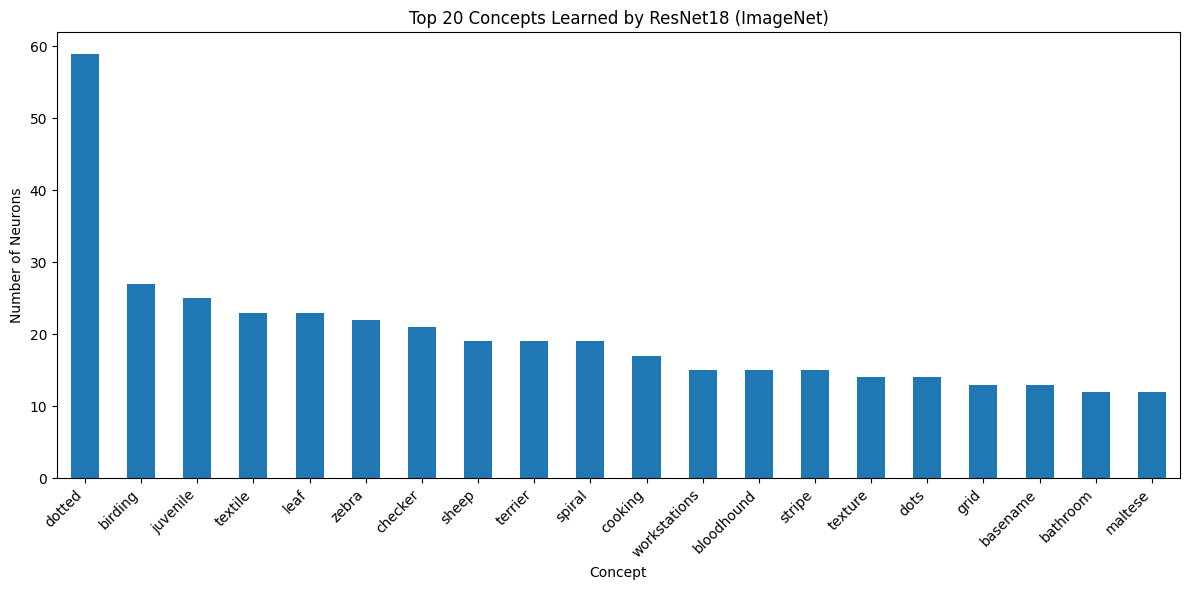

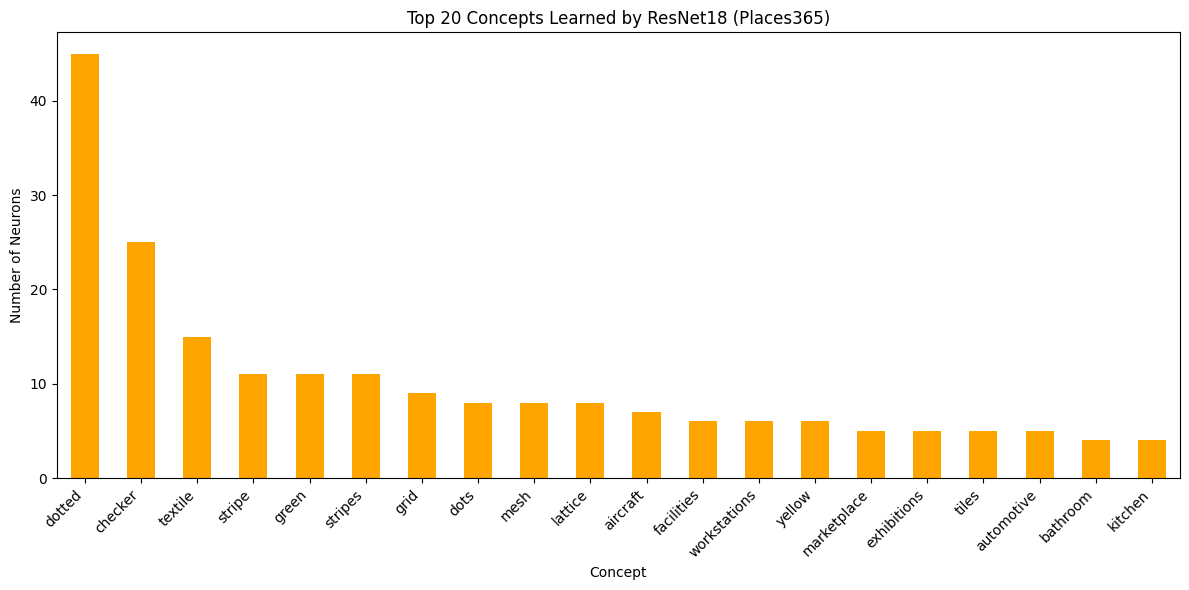

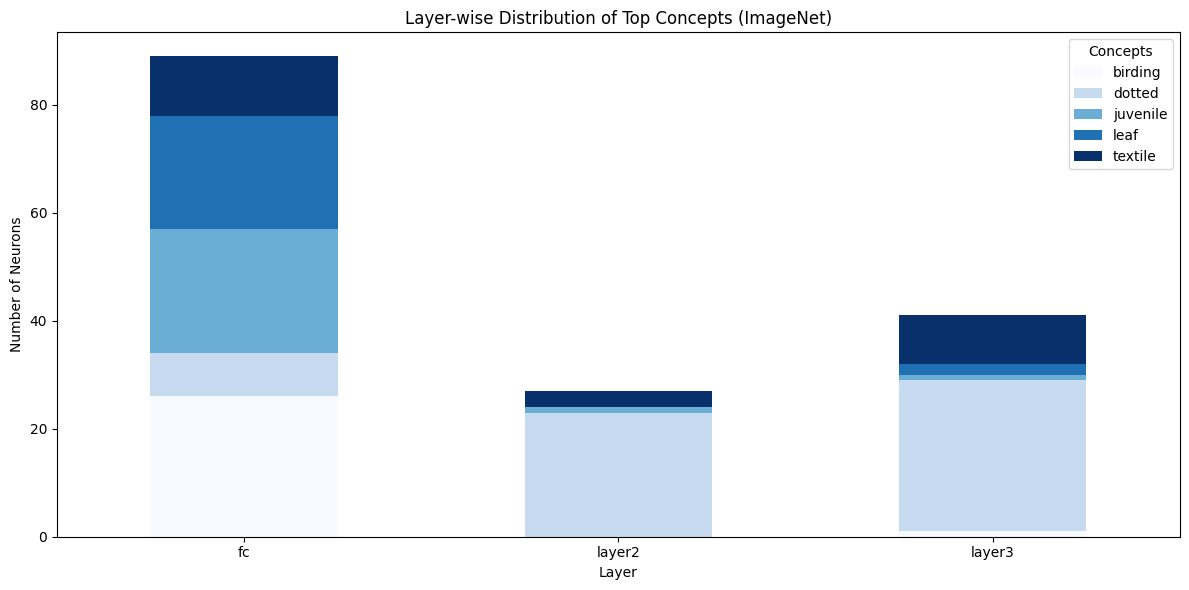

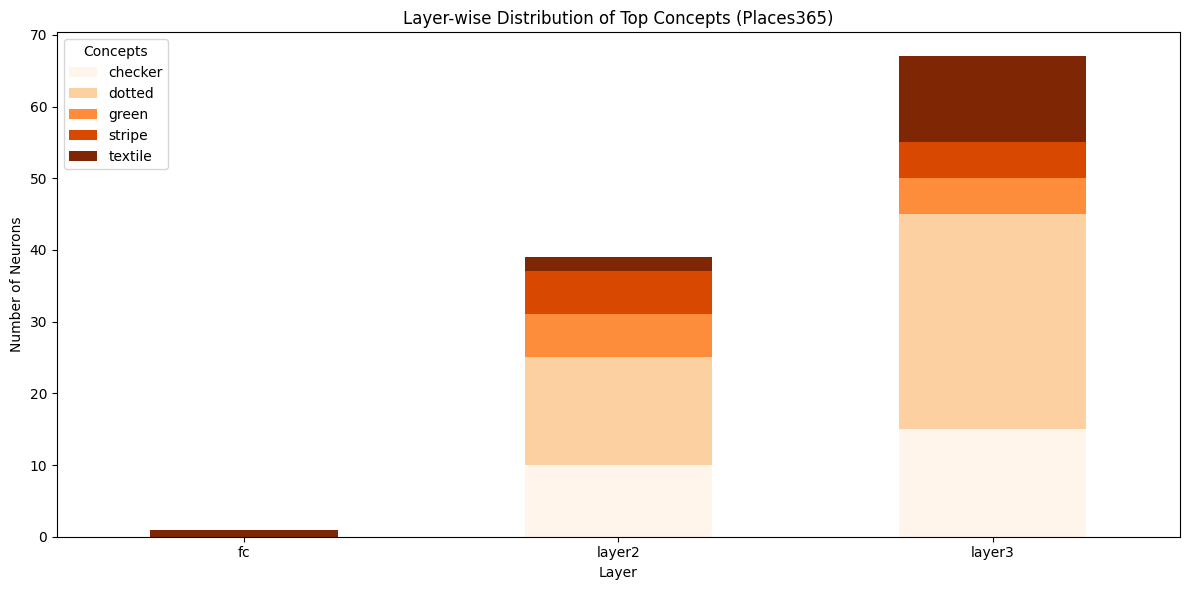

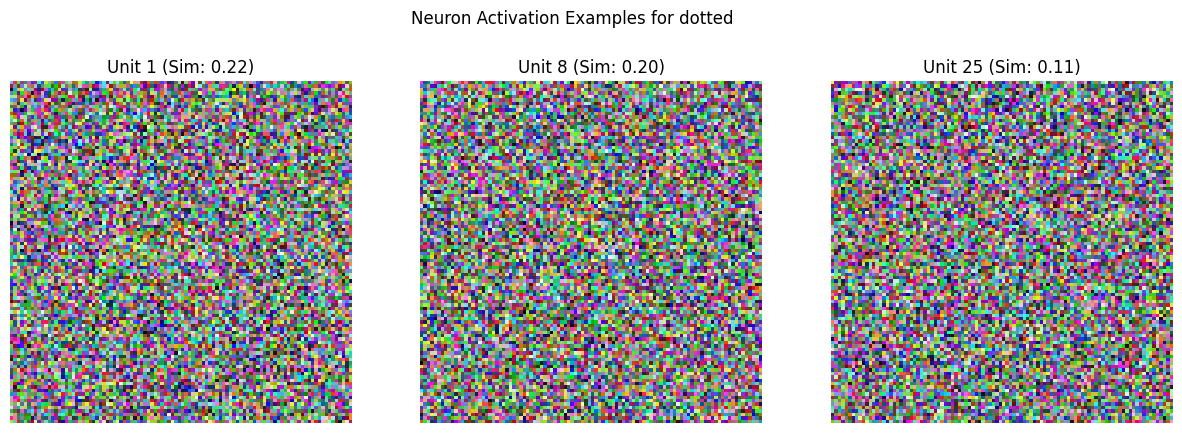

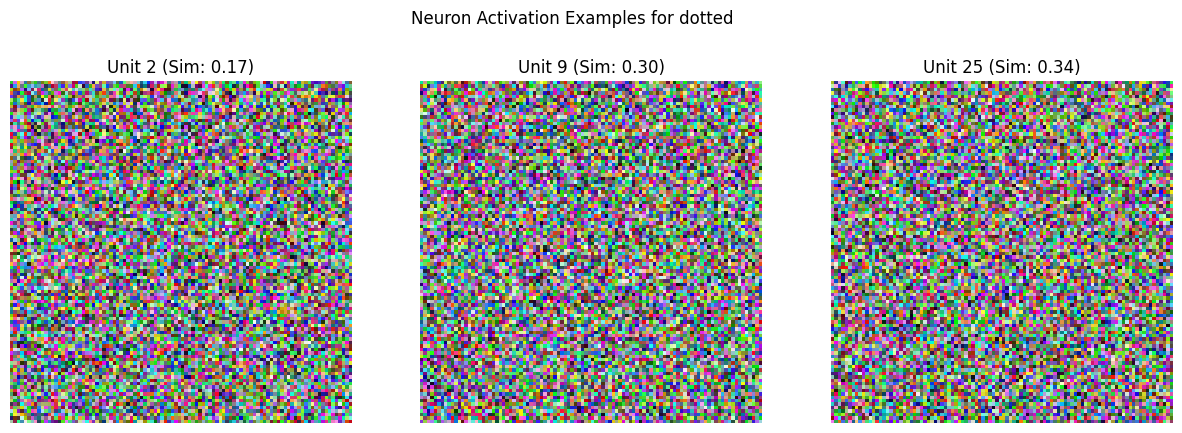

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both CSVs
imagenet_df = pd.read_csv('/kaggle/working/CLIP-dissect/results/resnet18_25_07_20_13_37/descriptions.csv')
places_df = pd.read_csv('/kaggle/working/CLIP-dissect/results/resnet18_places_25_07_20_13_40/descriptions.csv')

# Count concept frequencies
imagenet_counts = imagenet_df['description'].value_counts()
places_counts = places_df['description'].value_counts()

# 1. Histograms for Top 20 Concepts
# Plot top 20 concepts for ImageNet ResNet18
plt.figure(figsize=(12, 6))
imagenet_counts.head(20).plot(kind='bar')
plt.title("Top 20 Concepts Learned by ResNet18 (ImageNet)")
plt.xlabel("Concept")
plt.ylabel("Number of Neurons")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top 20 concepts for Places365 ResNet18
plt.figure(figsize=(12, 6))
places_counts.head(20).plot(kind='bar', color='orange')
plt.title("Top 20 Concepts Learned by ResNet18 (Places365)")
plt.xlabel("Concept")
plt.ylabel("Number of Neurons")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Stacked Bar Chart for Layer-wise Concept Distribution
# Assuming 'layer' column exists in the DataFrames
# Filter for top 5 concepts from ImageNet for clarity
top_concepts = imagenet_counts.head(5).index
layer_data_imagenet = imagenet_df[imagenet_df['description'].isin(top_concepts)].groupby(['layer', 'description']).size().unstack(fill_value=0)

layer_data_imagenet.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Blues')
plt.title('Layer-wise Distribution of Top Concepts (ImageNet)')
plt.xlabel('Layer')
plt.ylabel('Number of Neurons')
plt.xticks(rotation=0)
plt.legend(title='Concepts')
plt.tight_layout()
plt.show()

# Repeat for Places365 (if 'layer' column is present)
top_concepts_places = places_counts.head(5).index
layer_data_places = places_df[places_df['description'].isin(top_concepts_places)].groupby(['layer', 'description']).size().unstack(fill_value=0)

layer_data_places.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Oranges')
plt.title('Layer-wise Distribution of Top Concepts (Places365)')
plt.xlabel('Layer')
plt.ylabel('Number of Neurons')
plt.xticks(rotation=0)
plt.legend(title='Concepts')
plt.tight_layout()
plt.show()

# 3. Placeholder for Neuron Activation Visualization (Image Examples)
# Note: Requires image data (e.g., from CLIP Dissect). Here's a mock setup:
def plot_neuron_images(df, concept, num_images=3):
    # Filter rows for the specific concept
    concept_df = df[df['description'] == concept].head(num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, (idx, row) in enumerate(concept_df.iterrows()):
        # Placeholder: Replace with actual image loading logic (e.g., from file or URL)
        axes[i].imshow(np.random.rand(100, 100, 3))  # Random image placeholder
        axes[i].set_title(f'Unit {row["unit"]} (Sim: {row["similarity"]:.2f})')
        axes[i].axis('off')
    plt.suptitle(f'Neuron Activation Examples for {concept}')
    plt.show()

# Example usage with top concepts
plot_neuron_images(imagenet_df, imagenet_counts.index[0])  # First top concept from ImageNet
plot_neuron_images(places_df, places_counts.index[0])     # First top concept from Places365